In [1]:
# do the same thing as in the sine wave demo above but with one
# instance of a speakers vocals - prove that everything works correctly

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/pmc_development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
from importlib import reload
from collections import Counter
import pickle
import time

Using cache found in /Users/david/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /Users/david/.cache/torch/hub/snakers4_silero-vad_master


In [3]:
from data.pitch_tracking_database.load_data import *
speech_pitch_tracking_db = pickle.load(open(normalised_30,'rb'))
ads = speech_pitch_tracking_db['ads']

In [4]:
# split ads
developmentLabels = ["M03","M04","M05","M06","M07","M08","M09","M10","F05","F06","F07","F08","F09","F10",
                     "F03","F04"]
evaluationLabels = ["M01","M02","F01","F02"]
adsTrain = myads.subset(ads, developmentLabels)
adsEvaluate = myads.subset(ads, evaluationLabels)
numFilesPerSpeakerForEnrollment = 20
adsEnroll, adsDet = myads.split(adsEvaluate, numFilesPerSpeakerForEnrollment)
adsTest = adsDet
# adsDet, adsTest = myads.split(adsDet, 2)
# adsTrain.info('Train')
# adsEnroll.info('Enroll')
# adsTest.info('Test')

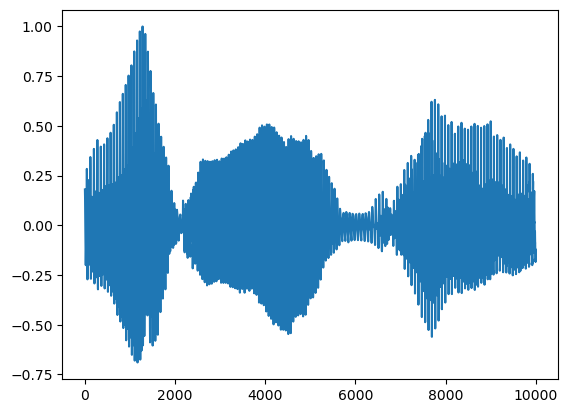

In [19]:
import matplotlib.pyplot as plt
speaker_audio = ads.data[0].flatten()[18000:28000]
plt.plot(speaker_audio)

In [20]:
import utils
import numpy as np
speaker_ap = utils.get_average_power(speaker_audio)
print('speaker average power = ', speaker_ap)

speaker average power =  0.03801008605957031


In [108]:
snr_db = 2
noise_ap = speaker_ap / np.power(10, snr_db / 10)
noise_ap

0.023982742963610096

In [109]:
speaker_audio.shape

(10000,)

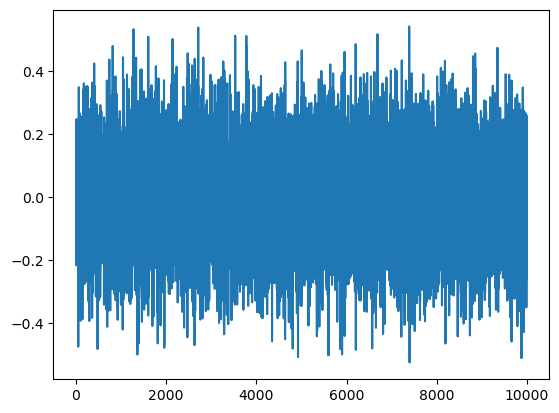

In [110]:
noise = np.random.normal(0, np.sqrt(noise_ap), speaker_audio.shape[0])
plt.plot(noise)

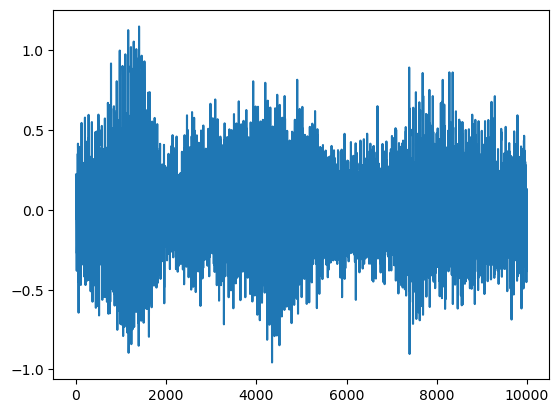

In [111]:
noisey_speaker = speaker_audio + noise
plt.plot(noisey_speaker)

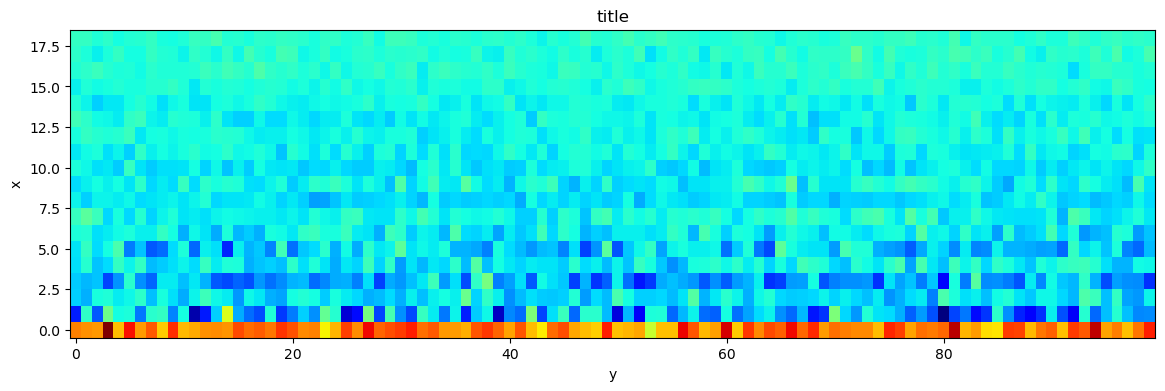

In [112]:
from spafe.features import mfcc
import config
import hmmlearn.hmm as hmm
from spafe.utils import vis
s1_feat = mfcc.mfcc(sig=speaker_audio, fs=config.SAMPLE_RATE, num_ceps=20, nfilts=20)[:,1:]
s1_hmm = hmm.GaussianHMM(1)
s1_hmm.fit(s1_feat)
s1_hmm_sampled, _ = s1_hmm.sample(100)
vis.show_features(s1_hmm_sampled, 'title', 'x', 'y')

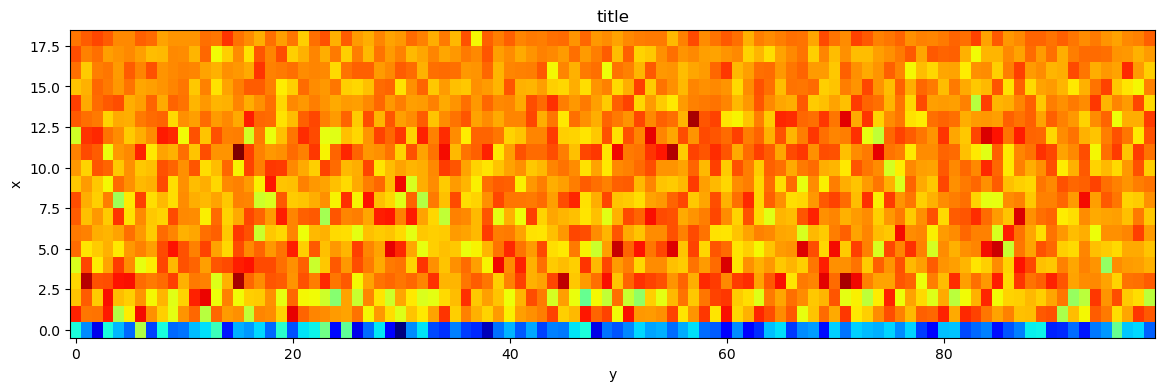

In [113]:
s2_feat = mfcc.mfcc(sig=noise, fs=config.SAMPLE_RATE, num_ceps=20, nfilts=20)[:,1:]
s2_hmm = hmm.GaussianHMM(1)
s2_hmm.fit(s2_feat)
s2_hmm_sampled, _ = s2_hmm.sample(100)
vis.show_features(s2_hmm_sampled, 'title', 'x', 'y')

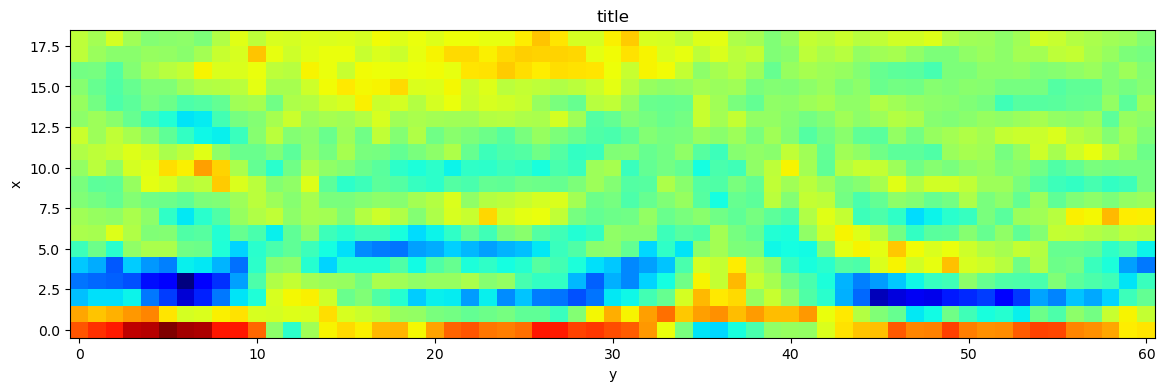

In [114]:
s3 = speaker_audio + noisey_speaker
s3_feat = mfcc.mfcc(sig=s3, fs=config.SAMPLE_RATE, num_ceps=20, nfilts=20)[:,1:]
vis.show_features(s3_feat[:100,:], 'title','x', 'y')

In [115]:
import classifiers.fhmm.helper_functions as hf
reload(hf)

def adapt_speaker_model(hmm_a: hmm.GaussianHMM, hmm_b: hmm.GaussianHMM, snr):
    # 01 deconstruct hmm
    n_states = hmm_a.transmat_.shape[0]

    signal_cept = hf.StatParams(hmm_a.means_, hmm_a.covars_)
    noise_cept = hf.StatParams(hmm_b.means_, hmm_b.covars_)

    pm_signal = hf.ParamMapper(signal_cept.mu)
    pm_noisy = hf.ParamMapper(noise_cept.mu)

    signal_lin = pm_signal.map_cepstral_to_linear(signal_cept)
    noise_lin = pm_noisy.map_cepstral_to_linear(noise_cept)

    # 03 combine using snr
    combined_lin = hf.StatParams(
        signal_lin.mu + snr * noise_lin.mu,
        signal_lin.cov + ((np.square(snr)) * noise_lin.cov)
    )

    # 04 combined params in cept
    combined_cept = pm_signal.map_linear_to_cepstral(combined_lin)
    combined_cept.mu[:, 0] = noise_cept.mu[:, 0]  # for some reason first gets confused
    # combined_cept['mu'][:, 1] = signal_cept['mu'][:, 1]

    # 05 combined hmm
    hmm_combined = hmm.GaussianHMM(n_states, covariance_type='diag')
    hmm_combined.n_features = hmm_a.covars_.shape[1]

    # hmm_combined.covars_ = np.array([np.diag(i) for i in combined_cept['cov']])
    hmm_combined.covars_ = np.array([np.diag(i) for i in combined_cept.cov])
    hmm_combined.means_ = combined_cept.mu
    hmm_combined.startprob_ = hmm_a.startprob_
    hmm_combined.transmat_ = hmm_a.transmat_

    return hmm_combined

# vis.show_features(cept_features, 'title', 'x', 'y')

def plot_params(true_hmm: hmm.GaussianHMM, new_hmm: hmm.GaussianHMM):
    x_axis = np.arange(len(true_hmm.means_.flatten()))
    true_var = np.diag(true_hmm.covars_[0, :, :])
    plt.stem(x_axis, true_hmm.means_.flatten(), linefmt='g')
    # plt.plot(x_axis, true_hmm.means_.flatten() + true_var, c='g')
    # plt.plot(x_axis, true_hmm.means_.flatten() - true_var, c='g')
    plt.plot(x_axis, true_var, c='g')

    new_var = np.diag(new_hmm.covars_[0, :, :])
    plt.stem(x_axis, new_hmm.means_.flatten(), linefmt='r', markerfmt ='*')
    # plt.plot(x_axis, new_hmm.means_.flatten() + new_var, c='r')
    # plt.plot(x_axis, new_hmm.means_.flatten() - new_var, c='r')
    plt.plot(x_axis, new_var, c='r')

-1319.963397858481 -1749.0838745259425 -2461.0224429222008


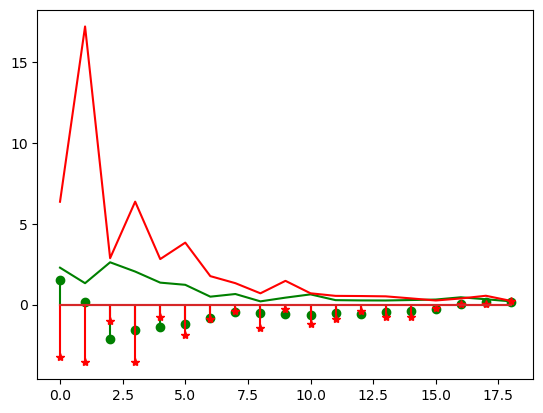

In [117]:
# this really doesn't look good, have a look at the paper where they use a global co-variance
# it probably works better

combined_hmm = adapt_speaker_model(s1_hmm, s2_hmm, 1)
s3_hmm = hmm.GaussianHMM(1)
s3_hmm.fit(s3_feat)
# combined_hmm.covars_ = np.array([np.diag(i) for i in s3_hmm.covars_])

combined_params = hf.StatParams(combined_hmm.means_, combined_hmm.covars_)
plot_params(s3_hmm, combined_hmm)
print(s3_hmm.score(s3_feat), combined_hmm.score(s3_feat), s1_hmm.score(s3_feat))